## US Airline Sentiment Analysis from Tweets (Corrected for an Imbalanced Data)

Saved as 'distilbert-base-uncased-US_Airline_Twitter_Sentiment_Analysis' on my HuggingFace profile

Source for the Dataset: https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

### Exploratory Data Analysis & Preprocessing in Pandas

#### Import Necessary Libraries

In [1]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

from pathlib import Path

import pandas as pd
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader

import datasets
from datasets import Dataset, DatasetDict, load_metric

import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import TrainingArguments, Trainer, AdamW, get_scheduler, set_seed, DataCollatorWithPadding

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

#### Versions of Libraries Used

In [2]:
print("Pandas:".ljust(10), pd.__version__)
print("NumPy:".ljust(10), np.__version__)
print("Torch:".ljust(10), torch.__version__)

Pandas:    1.4.4
NumPy:     1.23.3
Torch:     1.12.1


#### Ingest & Preprocess Data 

In [3]:
data = pd.read_csv('~/Desktop/Projects to Train/Twitter Sentiment Analysis/Tweets.csv', engine="c")

data['airline_sentiment'] = data['airline_sentiment'].str.strip()
data['text'] = data['text'].str.strip()

data.rename(columns={'airline_sentiment' : 'labels'}, inplace=True)

data.drop_duplicates(inplace=True)

data.drop(columns=['tweet_id', 'negativereason', 
                   'negativereason_confidence', 'tweet_coord', 
                   'tweet_created', 'tweet_location', 
                   'user_timezone', 'airline_sentiment_gold', 
                   'negativereason_gold', 'name', 'airline',
                   'airline_sentiment_confidence', 'retweet_count']
          , inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14604 entries, 0 to 14639
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   labels  14604 non-null  object
 1   text    14604 non-null  object
dtypes: object(2)
memory usage: 342.3+ KB


#### Visualize: Histogram of Text Lengths

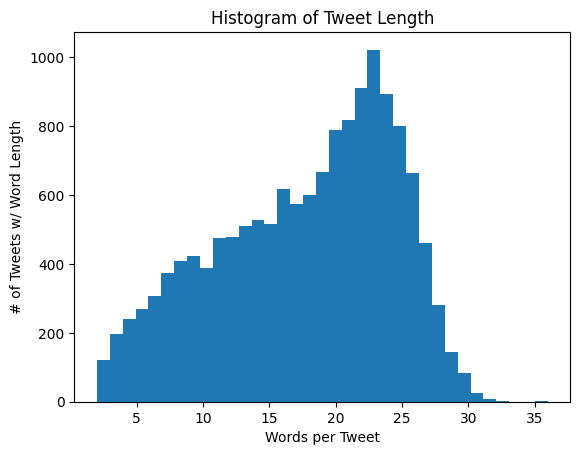

In [4]:
data['Tweet Length'] = data['text'].str.split().apply(len)
data.hist('Tweet Length', grid=False, bins=35)

plt.suptitle('')
plt.title('Histogram of Tweet Length')
plt.ylabel('# of Tweets w/ Word Length')
plt.xlabel('Words per Tweet')
plt.show()

#### Visualize: Description Lengths (By Output Class)

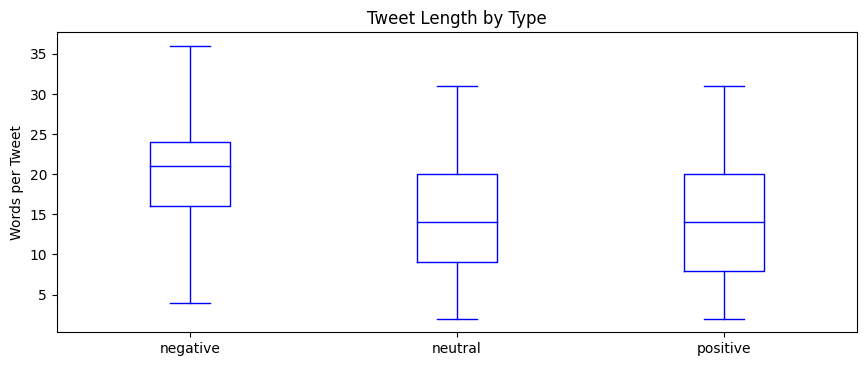

In [5]:
data.boxplot("Tweet Length", by="labels", grid=False, showfliers=False, color="Blue", figsize=(10,4))

plt.suptitle('')
plt.title('Tweet Length by Type')
plt.xlabel('')
plt.ylabel('Words per Tweet')
plt.show()

#### Trim Maximum Sample Length

In [6]:
data = data[data['Tweet Length'] < 36]

data = data.drop(columns=['Tweet Length'])
data.head()

,labels,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


#### Convert Labels from Strings to Integers

In [7]:
data['labels'].replace({'negative' : 0,'neutral' : 1, 'positive' : 2}, inplace=True)

data.head()

,labels,text
0,1,@VirginAmerica What @dhepburn said.
1,2,@VirginAmerica plus you've added commercials t...
2,1,@VirginAmerica I didn't today... Must mean I n...
3,0,@VirginAmerica it's really aggressive to blast...
4,0,@VirginAmerica and it's a really big bad thing...


#### Ensure that git lfs is Installed; Remember to ENter Access Token

In [8]:
!git lfs install

# HuggingFace Access Token ...

Git LFS initialized.


#### Convert Pandas DataFrame to Datasets

In [9]:
dataset = Dataset.from_pandas(data)
 
train_testvalid = dataset.train_test_split(test_size=0.20)
test_valid = train_testvalid['test'].train_test_split(test_size=0.50)

# Combine the train/test/valid into one datasetdict
ds = DatasetDict({
    'train' : train_testvalid['train'],
    'test' : test_valid['test'],
    'valid' : test_valid['train']
})

# Check the Output
print('training data shape:', ds['train'].shape)
print('testing data shape:', ds['test'].shape)
print('validation data shape:', ds['valid'].shape)
print(ds['train'].features)

training data shape: (11682, 3)
testing data shape: (1461, 3)
validation data shape: (1460, 3)
{'labels': Value(dtype='int64', id=None), 'text': Value(dtype='string', id=None), '__index_level_0__': Value(dtype='int64', id=None)}


#### Basic Values/Constants & Conversions

In [10]:
set_seed(42)
NUM_OF_LABELS = 3
MODEL_CKPT = 'distilbert-base-uncased'

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_INPUT_LENGTH = 46
BATCH_SIZE = 128

NUM_OF_EPOCHS = 8
LEARNING_RATE=2e-5
MODEL_NAME = f"{MODEL_CKPT}-US_Airline_Twitter_Sentiment_Analysis"

LABEL_NAMES  = ['negative','neutral', 'positive']

#### Tokenize Entire Dataset

In [11]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT, truncation=True, padding='longest')

# Method to Tokenize each Sample in the Dataset
def tokenize(batch):
    return tokenizer(batch['text'], max_length=MAX_INPUT_LENGTH, return_tensors="np")

# Map the 'Tokenize' Method to All Samples in the Entire Dataset
encoded_data = ds.map(tokenize, batched=True, batch_size=None)

print('training data shape:', encoded_data['train'].shape)
print('testing data shape:', encoded_data['test'].shape)
print('validation data shape:', encoded_data['valid'].shape)

  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/leedunn/Documents/nlpnn/nlp/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

training data shape: (11682, 5)
testing data shape: (1461, 5)
validation data shape: (1460, 5)


#### Print Sample to Ensure Edits Worked as Expected

In [12]:
print(encoded_data['train'].features)
print(encoded_data['train'])

{'labels': Value(dtype='int64', id=None), 'text': Value(dtype='string', id=None), '__index_level_0__': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
Dataset({
    features: ['labels', 'text', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 11682
})


#### Instantiate Model

In [13]:
model = (AutoModelForSequenceClassification.from_pretrained(MODEL_CKPT, num_labels=NUM_OF_LABELS).to(DEVICE))
print(f"There are {model.config.num_labels} unique label values in this dataset")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier

There are 3 unique label values in this dataset


#### Define Metrics Evaluation Function

In [14]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1_score": f1}

#### Instantiate Data Collator

In [15]:
data_collator = DataCollatorWithPadding(tokenizer)

#### Define TrainingArguments

In [16]:
LOGGING_STEPS = round(len(encoded_data["train"]) // BATCH_SIZE, 0) + 1

training_args = TrainingArguments(output_dir=MODEL_NAME,
                        num_train_epochs=NUM_OF_EPOCHS,
                        learning_rate=LEARNING_RATE,
                        per_device_train_batch_size=BATCH_SIZE, 
                        per_device_eval_batch_size=BATCH_SIZE, 
                        weight_decay=0.01,
                        logging_steps=LOGGING_STEPS,
                        logging_first_step=True,
                        logging_strategy='epoch', 
                        load_best_model_at_end=True,
                        metric_for_best_model="f1_score",
                        greater_is_better=True,
                        hub_strategy="checkpoint",
                        evaluation_strategy="epoch",
                        save_strategy="epoch",
                        log_level="error",
                        group_by_length=True,
                        disable_tqdm=False,
                        push_to_hub=True)

#### Subclass Trainer Function to Update Compute Loss Function for Imbalanced Dataset

In [17]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0, 3.0]))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

#### Instantiate Trainer

In [18]:
trainer = CustomTrainer(model=model, 
                  args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=encoded_data['train'], 
                  eval_dataset=encoded_data['valid'], 
                  data_collator=data_collator,
                  tokenizer=tokenizer)

Cloning https://huggingface.co/DunnBC22/distilbert-base-uncased-US_Airline_Twitter_Sentiment_Analysis into local empty directory.


#### Train this Model

In [19]:
results = trainer.train()

/Users/leedunn/Documents/nlpnn/nlp/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/736 [00:00<?, ?it/s]

{'loss': 1.0978, 'learning_rate': 1.997282608695652e-05, 'epoch': 0.01}
{'loss': 0.8015, 'learning_rate': 1.7500000000000002e-05, 'epoch': 1.0}


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.5483363270759583, 'eval_accuracy': 0.7952054794520548, 'eval_f1_score': 0.8018452790126995, 'eval_runtime': 87.3239, 'eval_samples_per_second': 16.719, 'eval_steps_per_second': 0.137, 'epoch': 1.0}
{'loss': 0.4795, 'learning_rate': 1.5000000000000002e-05, 'epoch': 2.0}


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.4993366301059723, 'eval_accuracy': 0.8232876712328767, 'eval_f1_score': 0.8266497180049651, 'eval_runtime': 86.9513, 'eval_samples_per_second': 16.791, 'eval_steps_per_second': 0.138, 'epoch': 2.0}
{'loss': 0.3995, 'learning_rate': 1.25e-05, 'epoch': 3.0}


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.588766872882843, 'eval_accuracy': 0.8205479452054795, 'eval_f1_score': 0.8159502183368431, 'eval_runtime': 86.0412, 'eval_samples_per_second': 16.969, 'eval_steps_per_second': 0.139, 'epoch': 3.0}
{'loss': 0.339, 'learning_rate': 1e-05, 'epoch': 4.0}


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.4934794306755066, 'eval_accuracy': 0.834931506849315, 'eval_f1_score': 0.8350190343859925, 'eval_runtime': 86.1523, 'eval_samples_per_second': 16.947, 'eval_steps_per_second': 0.139, 'epoch': 4.0}
{'loss': 0.2857, 'learning_rate': 7.500000000000001e-06, 'epoch': 5.0}


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.5100029110908508, 'eval_accuracy': 0.8335616438356165, 'eval_f1_score': 0.836962977801342, 'eval_runtime': 86.4788, 'eval_samples_per_second': 16.883, 'eval_steps_per_second': 0.139, 'epoch': 5.0}
{'loss': 0.2439, 'learning_rate': 5e-06, 'epoch': 6.0}


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.5275234580039978, 'eval_accuracy': 0.8376712328767123, 'eval_f1_score': 0.8399500536371522, 'eval_runtime': 87.695, 'eval_samples_per_second': 16.649, 'eval_steps_per_second': 0.137, 'epoch': 6.0}
{'loss': 0.2181, 'learning_rate': 2.5e-06, 'epoch': 7.0}


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.5462658405303955, 'eval_accuracy': 0.8417808219178082, 'eval_f1_score': 0.8426094217147808, 'eval_runtime': 88.4422, 'eval_samples_per_second': 16.508, 'eval_steps_per_second': 0.136, 'epoch': 7.0}
{'loss': 0.1983, 'learning_rate': 0.0, 'epoch': 8.0}


  0%|          | 0/12 [00:00<?, ?it/s]

{'eval_loss': 0.5593538284301758, 'eval_accuracy': 0.8465753424657534, 'eval_f1_score': 0.8471150310223431, 'eval_runtime': 86.1332, 'eval_samples_per_second': 16.95, 'eval_steps_per_second': 0.139, 'epoch': 8.0}
{'train_runtime': 13192.317, 'train_samples_per_second': 7.084, 'train_steps_per_second': 0.056, 'train_loss': 0.3711010687377142, 'epoch': 8.0}


### Assessing Results of Fine-Tuned Model

#### Calculate for Fine-Tuned Model

In [20]:
output_predictions = trainer.predict(encoded_data['valid'])

output_predictions.metrics

  0%|          | 0/12 [00:00<?, ?it/s]

{'test_loss': 0.5593538284301758,
 'test_accuracy': 0.8465753424657534,
 'test_f1_score': 0.8471150310223431,
 'test_runtime': 95.3686,
 'test_samples_per_second': 15.309,
 'test_steps_per_second': 0.126}

### Final Step

#### Push Fine-Tuned Model to HuggingFace Hub (My Profile)

In [33]:
trainer.push_to_hub(commit_message="All Dunn!!!")

To https://huggingface.co/DunnBC22/distilbert-base-uncased-US_Airline_Twitter_Sentiment_Analysis
   3177e1f..117effc  main -> main

To https://huggingface.co/DunnBC22/distilbert-base-uncased-US_Airline_Twitter_Sentiment_Analysis
   117effc..5024aa0  main -> main



'https://huggingface.co/DunnBC22/distilbert-base-uncased-US_Airline_Twitter_Sentiment_Analysis/commit/117effc88c942e49e43947c5b83a94920a0cebe5'